# Estimate transition : transversion ratio
Calculate transition transversion ratio by categorizing all instances of high confidence SNPs and counting transitions and transversions.

Across all strains transition rate : transversion rate is 1.95 for all strains unweighted. Previous analysis shows some variation by lineage, but that adds computational complexity.

In [14]:
import sys
import mtbvartools as vt
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm

# paths to VCBs
event_path = 'datasets/variants/global/241104_event_calls.vcb'

# miss settings
miss_threshold = 0.05

# bed mask path
mask_path = 'datasets/rlc_plus_lowmap_marin.bed'

In [15]:
# define bed mask
bed_mask = vt.bedToMask(mask_path, 4411532)

# define a miss count vector
miss_counts = np.load('datasets/global_miss_counts.npz').get('miss_counts')
total_strains = 55879
miss_mask = (miss_counts / total_strains) > miss_threshold

# generate a combined mask
combined_mask = np.any([
    bed_mask,
    miss_mask], axis=0)

In [16]:
# load in event vcb
event_vcb = vt.CallBytestream(
    event_path, True, True)

variant_counts = {
    p: 0 for p in product('ATGC', 'ATGC')}

for idx in tqdm(event_vcb.calls.row):
    pos, ref, alt = idx
    if len(ref) != 1 or len(alt) != 1 or combined_mask[pos - 1]:
        continue  # use only SNPs
    tta = event_vcb.calls.loc[idx] == 1
    ttr = event_vcb.calls.loc[idx] == 2
    # count forward
    variant_counts[
        (ref, alt)] += np.sum(tta)
    # count reverse
    variant_counts[
        (alt, ref)] += np.sum(ttr)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1496113/1496113 [03:56<00:00, 6338.28it/s]


In [17]:
tstv = pd.Series(
    variant_counts)

transversions = tstv.loc[[
    ('A', 'T'),
    ('A', 'C'),
    ('T', 'A'),
    ('T', 'G'),
    ('G', 'T'),
    ('G', 'C'),
    ('C', 'A'),
    ('C', 'G')]]
transitions = tstv.loc[[
    ('A', 'G'),
    ('G', 'A'),
    ('C', 'T'),
    ('T', 'C'),]]
transitions.sum() / transversions.sum()

np.float64(1.9480992183792265)

# pN/pS Variant Traversal - Lineage Level
Calculate pN/pS of all genes. Includes a few failsafes for poorly called sites:
- Removes sites with a miss fraction > 0.05 across all datasets.
- Removes sites in poor mapability regions (https://github.com/farhat-lab/mtb-illumina-wgs-evaluation - "RLC Regions & Low Pileup Mappability Regions combined")

Only includes SNP calls and does not consider if MSS variants are functional or not.

In [1]:
import sys, dask
import mtbvartools as vt
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm
from mtbvartools.dasktools import startClient, subproc


def getChildNodeMask(tree, target_label, vcb_path):
    child_node_labels = [target_label] + [n.label for n in tree.find_node_with_label(target_label).postorder_iter()]
    event_vcb = vt.CallBytestream(
        vcb_path, True, False)
    vcb_mask = np.isin(event_vcb.calls.col, child_node_labels)
    return vcb_mask

@subproc
def getCDSpNpS(geneid, gdata, ts_tv):
    # load in event vcb
    event_vcb = vt.CallBytestream(
        event_path, True, False)
    # load in annotation CSV
    variant_annotations = pd.read_csv(
        annotations_path)
    # get codon mask
    global_mask = np.load(mask_path)
    local_mask = vt.getCodonMask(
        global_mask, gdata.start, gdata.end + 1)

    # calculate mask fraction
    gene_length = (gdata.end - gdata.start) + 1
    n_sites = np.sum(local_mask[gdata.start:gdata.end+1] == False)
    fraction_called = n_sites / gene_length

    # get site counts
    syn_possible, mss_possible = vt.getSynNSynCounts(
        fasta_path, gdata.start, gdata.end+1, local_mask, k=ts_tv, is_rev=bool(int(gdata.strand)))
    
    # get MSS SNPs vector
    mss_snps = np.all([
        variant_annotations.ref.str.len() == 1,
        variant_annotations.alt.str.len() == 1,
        variant_annotations.Annotation == 'missense_variant',
        ~local_mask[variant_annotations.pos.values.astype(int) - 1],
        variant_annotations.Gene_ID == geneid],
        axis=0)
    mss_tta = np.zeros(
        len(event_vcb.calls.col), dtype='uint32')
    mss_ttr = np.zeros(
        len(event_vcb.calls.col), dtype='uint32')
    for i, rdata in variant_annotations.loc[mss_snps].iterrows():
        try:
            vevents = event_vcb.calls.loc[
                (rdata.pos, rdata.ref, rdata.alt)]
        except KeyError:
            continue  # ignore skipped positions in event calling
        # identify [nodes...] with transtions to alt or ref for each mss_snp
        # then cumsum to get counts
        mss_tta = np.sum(
            [mss_tta, vevents == 1], axis=0)
        mss_ttr = np.sum(
            [mss_ttr, vevents == 2], axis=0)

    # get SYN SNPs vector
    syn_snps = np.all([
        variant_annotations.ref.str.len() == 1,
        variant_annotations.alt.str.len() == 1,
        variant_annotations.Annotation == 'synonymous_variant',
        ~local_mask[variant_annotations.pos.values.astype(int) - 1],
        variant_annotations.Gene_ID == geneid],
        axis=0)
    syn_tta = np.zeros(
        len(event_vcb.calls.col), dtype='uint32')
    syn_ttr = np.zeros(
        len(event_vcb.calls.col), dtype='uint32')
    for i, rdata in variant_annotations.loc[syn_snps].iterrows():
        try:
            vevents = event_vcb.calls.loc[
                (rdata.pos, rdata.ref, rdata.alt)]
        except KeyError:
            continue  # ignore skipped positions in event calling
        # identify [nodes...] with transtions to alt or ref for each mss_snp
        # then cumsum to get counts
        syn_tta = np.sum(
            [syn_tta, vevents == 1], axis=0)
        syn_ttr = np.sum(
            [syn_ttr, vevents == 2], axis=0)
    event_vcb.close()
    return {
        'geneid': geneid,
        'n_sites': n_sites,
        'fraction_called': fraction_called,
        'mss_possible': mss_possible,
        'syn_possible': syn_possible,
        'mss_tta': mss_tta,
        'mss_ttr': mss_ttr,
        'syn_tta': syn_tta,
        'syn_ttr': syn_ttr,
        'mss_norm': (mss_tta + mss_ttr) / mss_possible,
        'syn_norm': (syn_tta + syn_ttr) / syn_possible}


# paths to VCBs
variant_path = 'datasets/variants/global/241104_variant_calls.vcb'
ancestor_path = 'datasets/variants/global/241104_ancestor_calls.vcb'
event_path = 'datasets/variants/global/241104_event_calls.vcb'


annotations_path = 'datasets/variants/global/241104_event_calls.vcb/event_calls.annotated.csv'
fasta_path = 'datasets/Mtb_h37rv.fasta'

# miss settings
miss_threshold = 0.05

# transition transversion rate
ts_tv = 1.95

# load gene table
gene_table = pd.read_csv('datasets/gt_mtb_h37rv.csv', index_col=0)

# define bed mask
bed_mask = vt.bedToMask('datasets/rlc_plus_lowmap_marin.bed', 4411532)

# define a miss count vector
miss_counts = np.load('datasets/global_miss_counts.npz').get('miss_counts')
total_strains = 55260
miss_mask = (miss_counts / total_strains) > miss_threshold

# generate a combined mask
combined_mask = np.any([
    bed_mask,
    miss_mask], axis=0)

mask_path = 'tmp/combined_mask.npy'
np.save(mask_path, combined_mask)

In [2]:
# load tree to generate 
tree = vt.loadTree(
    'datasets/variants/global/241104_event_calls.vcb/tree.nwk')

# generate node masks
node_masks = {
    'total': np.asarray(vt.CallBytestream(event_path, True, False).calls.col) != 'canettii',
    'L1_mask': getChildNodeMask(tree, 'internal4119', event_path),
    'L2_mask': getChildNodeMask(tree, 'internal26428', event_path),
    'L3_mask': getChildNodeMask(tree, 'internal10170', event_path),
    'L4_mask': getChildNodeMask(tree, 'internal55169', event_path)}

client = startClient(
    n_workers=16,
    use_local=True)

futures = []
for geneid, gdata in list(gene_table.loc[gene_table.locus_type == 'CDS'].iterrows()):
    futures.append(
        client.submit(getCDSpNpS, geneid, gdata, ts_tv))

pNpS_results = []
for f in tqdm(futures):
    results = f.result()
    f.release()
    row_dict = {
        ('summary', 'n_sites'): results['n_sites'],
        ('summary', 'fraction_called'): results['fraction_called'],
        ('summary', 'syn_possible'): results['syn_possible'],
        ('summary', 'mss_possible'): results['mss_possible'],}
    for name, mask in node_masks.items():
        row_dict[(name, 'n_syn')] = np.sum(results['syn_tta'][mask] + results['syn_ttr'][mask])
        row_dict[(name, 'n_mss')] = np.sum(results['mss_tta'][mask] + results['mss_ttr'][mask])
        row_dict[(name, 'pNpS')] = np.sum(results['mss_norm'][mask]) / np.sum(results['syn_norm'][mask])
    pNpS_results.append(
        pd.Series(data=row_dict, name=results['geneid']))

2025-03-15 10:59:34 - Launching LocalCluster client (16 workers)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3906/3906 [28:54<00:00,  2.25it/s]


In [3]:
client.shutdown()

In [4]:
results_df = pd.DataFrame(pNpS_results)
results_df.insert(
    0, ('summary', 'gene'),  gene_table.loc[results_df.index, 'gene'].values.astype(str))
results_df.to_csv('outputs/tables/TableS1_pNpS_by_lineage.csv')

# pN/pS Enrichment
Category enrichment of high pNpS values (>2) for mycobrowser categories + transcription factor calls .

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import dendropy
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
plt.style.use('paper_style.mplstyle')

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

In [17]:
# load in possible regulators list
sherman_oe = pd.read_csv(
    'datasets/sherman_lab_oe_genes.csv')
sherman_chip = pd.read_csv(
    'datasets/sherman_lab_chip_genes.csv')
sherman_tf_geneid = np.union1d(
    sherman_oe, sherman_chip)

# load in mycobrowser categories
mycobrowser_df = pd.read_csv(
    'datasets/Mycobacterium_tuberculosis_H37Rv_txt_v5.txt',
    delimiter='\t', index_col='Locus')
mycobrowser_df = mycobrowser_df.loc[mycobrowser_df.Feature == 'CDS']

Filter genes based on having a sufficient numerator and denominator (n=5) for syn and mss variants as well as a high proportion (>95%) of low miss data.

In [46]:
pNpS_df = pd.read_csv(
    'outputs/tables/TableS1_pNpS_by_lineage.csv',
    index_col=0, header=[0, 1])
pNpS_mask = np.all([
    pNpS_df.loc[:, ('summary', 'fraction_called')] >= 0.95,
    pNpS_df.loc[:, ('total', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('total', 'n_mss')] >= 5,
    pNpS_df.loc[:, ('L1_mask', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('L1_mask', 'n_mss')] >= 5,
    pNpS_df.loc[:, ('L2_mask', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('L2_mask', 'n_mss')] >= 5,
    pNpS_df.loc[:, ('L3_mask', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('L3_mask', 'n_mss')] >= 5,
    pNpS_df.loc[:, ('L4_mask', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('L4_mask', 'n_mss')] >= 5,], axis=0)
print(f'{pNpS_mask.sum()} / {len(pNpS_mask)} surviving mask.')
pNpS_filtered = pNpS_df.loc[pNpS_mask]

3042 / 3906 surviving mask.


In [47]:
upper_threshold = 2

maximum_pNpS = np.max(pNpS_filtered.loc[
    :, [('L1_mask', 'pNpS'), ('L2_mask', 'pNpS'), ('L3_mask', 'pNpS'), ('L4_mask', 'pNpS')]], axis=1)

output_data = []
# get values for mycobrowser functional categories
for category in np.unique(mycobrowser_df.Functional_Category):
    category_indexes = mycobrowser_df.index[
        mycobrowser_df.loc[:, 'Functional_Category'] == category].intersection(maximum_pNpS.index)
    noncategory_indexes = mycobrowser_df.index[
        mycobrowser_df.loc[:, 'Functional_Category'] != category].intersection(maximum_pNpS.index)
    if len(category_indexes) == 0:
        continue
    cat_above = np.sum(maximum_pNpS.loc[category_indexes] >= upper_threshold)
    cat_below = np.sum(maximum_pNpS.loc[category_indexes] < upper_threshold)
    not_cat_above = np.sum(maximum_pNpS.loc[noncategory_indexes] >= upper_threshold)
    not_cat_below = np.sum(maximum_pNpS.loc[noncategory_indexes] < upper_threshold)
    category_rate = cat_above / (cat_above + cat_below)
    not_category_rate = not_cat_above / (not_cat_above + not_cat_below)
    fisher_result = fisher_exact([
        [cat_above, cat_below],
        [not_cat_above, not_cat_below]])
    output_data.append(pd.Series(
        data={'category_above': cat_above, 'category_total': (cat_above + cat_below), 'category_rate': category_rate, 'p_value': fisher_result.pvalue},
        name=category))
    fisher_result.pvalue

# get enrichment values for sherman lab key cateogories
category_indexes = maximum_pNpS.index.intersection(sherman_tf_geneid)
noncategory_indexes = maximum_pNpS.index.difference(sherman_tf_geneid)
cat_above = np.sum(maximum_pNpS.loc[category_indexes] >= upper_threshold)
cat_below = np.sum(maximum_pNpS.loc[category_indexes] < upper_threshold)
not_cat_above = np.sum(maximum_pNpS.loc[noncategory_indexes] >= upper_threshold)
not_cat_below = np.sum(maximum_pNpS.loc[noncategory_indexes] < upper_threshold)
category_rate = cat_above / (cat_above + cat_below)
not_category_rate = not_cat_above / (not_cat_above + not_cat_below)
fisher_result = fisher_exact([
    [cat_above, cat_below],
    [not_cat_above, not_cat_below]])
output_data.append(pd.Series(
    data={'category_above': cat_above, 'category_total': (cat_above + cat_below), 'category_rate': category_rate, 'p_value': fisher_result.pvalue},
    name='transcription factors'))

total_rate = np.sum(maximum_pNpS >= upper_threshold) / len(maximum_pNpS)
print(total_rate)

category_enrichment = pd.DataFrame(
    output_data).sort_values('category_rate')
category_enrichment.loc[:, 'log_pval'] = -np.log10(
    category_enrichment.p_value)

category_enrichment

0.01775147928994083


,category_above,category_total,category_rate,p_value,log_pval
PE/PPE,0.0,47.0,0.000000,1.000000,-0.000000
insertion seqs and phages,0.0,15.0,0.000000,1.000000,-0.000000
unknown,0.0,7.0,0.000000,1.000000,-0.000000
cell wall and cell processes,6.0,646.0,0.009288,0.066349,1.178166
lipid metabolism,3.0,230.0,0.013043,0.795394,0.099418
intermediary metabolism and respiration,11.0,835.0,0.013174,0.282809,0.548507
conserved hypotheticals,15.0,757.0,0.019815,0.634283,0.197717
"virulence, detoxification, adaptation",3.0,141.0,0.021277,0.737769,0.132080
regulatory proteins,7.0,166.0,0.042169,0.025690,1.590232
information pathways,9.0,198.0,0.045455,0.007155,2.145414


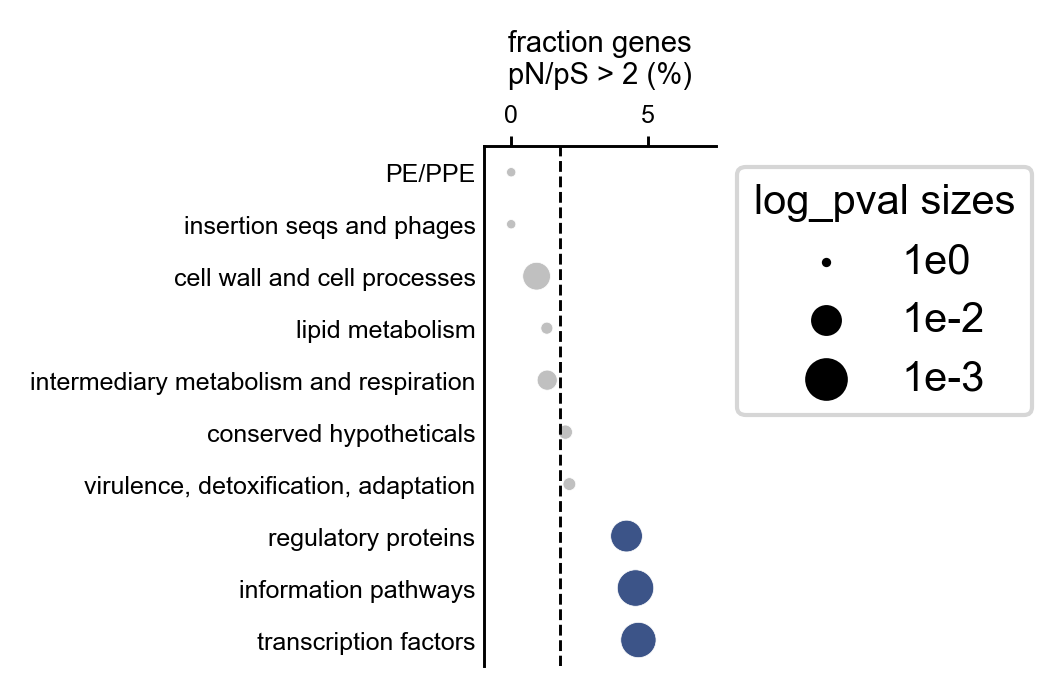

In [52]:
output_dir = 'outputs/figures'
output_name = '1B_pNpS_categories.pdf'

fig, ax = plt.subplots(1, 1, figsize=(1, 2.25))

category_enrichment_plt = category_enrichment.loc[category_enrichment.index != 'unknown'].reset_index()
category_enrichment_plt.loc[:, 'direction'] = 'none'
category_enrichment_plt.loc[
    np.all([
        category_enrichment_plt.p_value < 0.05,
        category_enrichment_plt.category_rate < total_rate], axis=0), 'direction'] = 'lower'
category_enrichment_plt.loc[
    np.all([
        category_enrichment_plt.p_value < 0.05,
        category_enrichment_plt.category_rate > total_rate], axis=0), 'direction'] = 'higher'
category_enrichment_plt.loc[
    :, 'category_rate'] = category_enrichment_plt.loc[:, 'category_rate'] * 100


sns.scatterplot(
    category_enrichment_plt,
    ax=ax,
    x="category_rate",
    y="index",
    hue='direction',
    size='log_pval',
    palette={'higher': colors['dblue'], 'none': colors['gray'], 'lower': colors['dred']},
    sizes=(5,105),
    marker='o',
    size_norm=(0, 3),
    legend=False)
ax.axvline(total_rate * 100, 0, 1, color='k', lw=0.7, linestyle='--')

# Manually create the legend
handles, labels = ax.get_legend_handles_labels()
size_legend = [
    plt.scatter([-1], [-1], marker='o', lw=0, color='k', s=s)
    for s in [5, 55, 105]]
labels_size = ['1e0', '1e-2', '1e-3']
legend2 = ax.legend(size_legend, labels_size, title='log_pval sizes', loc='upper right')

ax.set_xlim(-1, 7.5)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 1)
ax.tick_params(axis='y', length=0)
sns.despine(bottom=True, top=False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel('fraction genes\npN/pS > 2 (%)', labelpad=5)
ax.set_ylabel('')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Global pN/pS
Global pNpS value plot.

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import dendropy
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
plt.style.use('paper_style.mplstyle')

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

Filter genes based on having a sufficient numerator and denominator (n=5) for syn and mss variants as well as a high proportion (>95%) of low miss data.

In [54]:
pNpS_df = pd.read_csv(
    'outputs/tables/TableS1_pNpS_by_lineage.csv',
    index_col=0, header=[0, 1])
pNpS_mask = np.all([
    pNpS_df.loc[:, ('summary', 'fraction_called')] >= 0.95,
    pNpS_df.loc[:, ('total', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('total', 'n_mss')] >= 5,
    pNpS_df.loc[:, ('L1_mask', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('L1_mask', 'n_mss')] >= 5,
    pNpS_df.loc[:, ('L2_mask', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('L2_mask', 'n_mss')] >= 5,
    pNpS_df.loc[:, ('L3_mask', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('L3_mask', 'n_mss')] >= 5,
    pNpS_df.loc[:, ('L4_mask', 'n_syn')] >= 5,
    pNpS_df.loc[:, ('L4_mask', 'n_mss')] >= 5,], axis=0)
print(f'{pNpS_mask.sum()} / {len(pNpS_mask)} surviving mask.')
pNpS_filtered = pNpS_df.loc[pNpS_mask]

3042 / 3906 surviving mask.


0.6938392779268299 mean


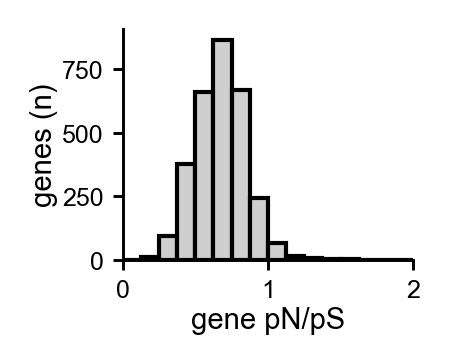

In [68]:
output_dir = 'outputs/figures'
output_name = 'S1A_pNpS_total.pdf'

total_pNpS = pNpS_filtered.loc[:, pd.IndexSlice['total', 'pNpS']]
print(f'{np.mean(total_pNpS)} mean')

fig, ax = plt.subplots(1, 1, figsize=(1.25, 1))
sns.histplot(
    ax=ax,
    data=pNpS_filtered.loc[:, pd.IndexSlice['total', 'pNpS']],
    binrange=(0, 2),
    bins=16,
    color='silver',
    linewidth=1)

sns.despine()
ax.set_xlim(0, 2)
ax.set_ylabel('genes (n)')
ax.set_xlabel('gene pN/pS')

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# Non-figure analyses

## pN/pS ignoring revertant variants
Calculate pN/pS of all genes as above except ignore **all** variants with reversions - probably an undercount of the true pNpS in genes with strong evolutionary pressure at a given loci.

In [10]:
import sys, dask
import mtbvartools as vt
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm
from mtbvartools.dasktools import startClient, subproc


def getChildNodeMask(tree, target_label, vcb_path):
    child_node_labels = [target_label] + [n.label for n in tree.find_node_with_label(target_label).postorder_iter()]
    event_vcb = vt.CallBytestream(
        vcb_path, True, False)
    vcb_mask = np.isin(event_vcb.calls.col, child_node_labels)
    return vcb_mask

@subproc
def getCDSpNpS_reversions(geneid, gdata, ts_tv, max_reversions=0):
    # load in event vcb
    event_vcb = vt.CallBytestream(
        event_path, True, False)
    # load in annotation CSV
    variant_annotations = pd.read_csv(
        annotations_path)
    # get codon mask
    global_mask = np.load(mask_path)
    local_mask = vt.getCodonMask(
        global_mask, gdata.start, gdata.end + 1)

    # calculate mask fraction
    gene_length = (gdata.end - gdata.start) + 1
    n_sites = np.sum(local_mask[gdata.start:gdata.end+1] == False)
    fraction_called = n_sites / gene_length

    # get site counts
    syn_possible, mss_possible = vt.getSynNSynCounts(
        fasta_path, gdata.start, gdata.end+1, local_mask, k=ts_tv, is_rev=bool(int(gdata.strand)))
    
    # get MSS SNPs vector
    mss_snps = np.all([
        variant_annotations.ref.str.len() == 1,
        variant_annotations.alt.str.len() == 1,
        variant_annotations.Annotation == 'missense_variant',
        ~local_mask[variant_annotations.pos.values.astype(int) - 1],
        variant_annotations.Gene_ID == geneid,
        variant_annotations.reversions_to_alt + variant_annotations.reversions_to_ref <= max_reversions],
        axis=0)
    mss_tta = np.zeros(
        len(event_vcb.calls.col), dtype='uint32')
    mss_ttr = np.zeros(
        len(event_vcb.calls.col), dtype='uint32')
    for i, rdata in variant_annotations.loc[mss_snps].iterrows():
        try:
            vevents = event_vcb.calls.loc[
                (rdata.pos, rdata.ref, rdata.alt)]
        except KeyError:
            continue  # ignore skipped positions in event calling
        # identify [nodes...] with transtions to alt or ref for each mss_snp
        # then cumsum to get counts
        mss_tta = np.sum(
            [mss_tta, vevents == 1], axis=0)
        mss_ttr = np.sum(
            [mss_ttr, vevents == 2], axis=0)

    # get SYN SNPs vector
    syn_snps = np.all([
        variant_annotations.ref.str.len() == 1,
        variant_annotations.alt.str.len() == 1,
        variant_annotations.Annotation == 'synonymous_variant',
        ~local_mask[variant_annotations.pos.values.astype(int) - 1],
        variant_annotations.Gene_ID == geneid,
        variant_annotations.reversions_to_alt + variant_annotations.reversions_to_ref <= max_reversions],
        axis=0)
    syn_tta = np.zeros(
        len(event_vcb.calls.col), dtype='uint32')
    syn_ttr = np.zeros(
        len(event_vcb.calls.col), dtype='uint32')
    for i, rdata in variant_annotations.loc[syn_snps].iterrows():
        try:
            vevents = event_vcb.calls.loc[
                (rdata.pos, rdata.ref, rdata.alt)]
        except KeyError:
            continue  # ignore skipped positions in event calling
        # identify [nodes...] with transtions to alt or ref for each mss_snp
        # then cumsum to get counts
        syn_tta = np.sum(
            [syn_tta, vevents == 1], axis=0)
        syn_ttr = np.sum(
            [syn_ttr, vevents == 2], axis=0)
    event_vcb.close()
    return {
        'geneid': geneid,
        'n_sites': n_sites,
        'fraction_called': fraction_called,
        'mss_possible': mss_possible,
        'syn_possible': syn_possible,
        'mss_tta': mss_tta,
        'mss_ttr': mss_ttr,
        'syn_tta': syn_tta,
        'syn_ttr': syn_ttr,
        'mss_norm': (mss_tta + mss_ttr) / mss_possible,
        'syn_norm': (syn_tta + syn_ttr) / syn_possible}


# paths to VCBs
variant_path = 'datasets/variants/global/241104_variant_calls.vcb'
ancestor_path = 'datasets/variants/global/241104_ancestor_calls.vcb'
event_path = 'datasets/variants/global/241104_event_calls.vcb'


annotations_path = 'datasets/variants/global/241104_event_calls.vcb/event_calls.annotated.csv'
fasta_path = 'datasets/Mtb_h37rv.fasta'

# miss settings
miss_threshold = 0.05

# transition transversion rate
ts_tv = 1.95

# load gene table
gene_table = pd.read_csv('datasets/gt_mtb_h37rv.csv', index_col=0)

# define bed mask
bed_mask = vt.bedToMask('datasets/rlc_plus_lowmap_marin.bed', 4411532)

# define a miss count vector
miss_counts = np.load('datasets/global_miss_counts.npz').get('miss_counts')
total_strains = 55260
miss_mask = (miss_counts / total_strains) > miss_threshold

# generate a combined mask
combined_mask = np.any([
    bed_mask,
    miss_mask], axis=0)

mask_path = 'tmp/combined_mask.npy'
np.save(mask_path, combined_mask)

In [11]:
# load tree to generate 
tree = vt.loadTree(
    'datasets/variants/global/241104_event_calls.vcb/tree.nwk')

# generate node masks
node_masks = {
    'total': np.asarray(vt.CallBytestream(event_path, True, False).calls.col) != 'canettii',
    'L1_mask': getChildNodeMask(tree, 'internal4119', event_path),
    'L2_mask': getChildNodeMask(tree, 'internal26428', event_path),
    'L3_mask': getChildNodeMask(tree, 'internal10170', event_path),
    'L4_mask': getChildNodeMask(tree, 'internal55169', event_path)}

client = startClient(
    n_workers=16,
    use_local=True)

futures = []
for geneid, gdata in list(gene_table.loc[gene_table.locus_type == 'CDS'].iterrows()):
    futures.append(
        client.submit(getCDSpNpS_reversions, geneid, gdata, ts_tv))

pNpS_results = []
for f in tqdm(futures):
    results = f.result()
    f.release()
    row_dict = {
        ('summary', 'n_sites'): results['n_sites'],
        ('summary', 'fraction_called'): results['fraction_called'],
        ('summary', 'syn_possible'): results['syn_possible'],
        ('summary', 'mss_possible'): results['mss_possible'],}
    for name, mask in node_masks.items():
        row_dict[(name, 'n_syn')] = np.sum(results['syn_tta'][mask] + results['syn_ttr'][mask])
        row_dict[(name, 'n_mss')] = np.sum(results['mss_tta'][mask] + results['mss_ttr'][mask])
        row_dict[(name, 'pNpS')] = np.sum(results['mss_norm'][mask]) / np.sum(results['syn_norm'][mask])
    pNpS_results.append(
        pd.Series(data=row_dict, name=results['geneid']))

2025-03-15 11:50:45 - Launching LocalCluster client (16 workers)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3906/3906 [28:47<00:00,  2.26it/s]


In [12]:
client.shutdown()

In [13]:
results_df = pd.DataFrame(pNpS_results)
results_df.insert(
    0, ('summary', 'gene'),  gene_table.loc[results_df.index, 'gene'].values.astype(str))
results_df.to_csv('outputs/tables/BonusTable1_pNpS_no_reversions.csv')